In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
from tqdm import tqdm_notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped
env.frameskip = 4

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
DEVICE_ID = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(DEVICE_ID)
print("Device : {}".format(device))

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
Device : cuda
Number of actions : 4


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 100000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.
class StateHolder:
    def __init__(self, frame):
        self.deq = deque(maxlen=STATE_SIZE)
        for _ in range(STATE_SIZE):
            self.deq.append(frame)
    # заталкивание кадра
    def push(self,frame):
        self.deq.append(frame)
    # получение кадров
    def get(self):
        return torch.cat([f for f in self.deq]).unsqueeze(dim=0)
    # очистка очереди    
    def reset(self):
        self.deq.clear()
    
    
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# Задание 2. Собрать архитектуру сети (DQN)
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        
        # инициализация слоев
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.prehead = nn.Linear(64 * 7 * 7, 512)
        self.head = nn.Linear(512, 4)
        
        # инициализация весов
        nn.init.xavier_normal_(self.conv1.weight, gain=nn.init.calculate_gain('conv2d'))
        nn.init.xavier_normal_(self.conv2.weight, gain=nn.init.calculate_gain('conv2d'))
        nn.init.xavier_normal_(self.conv3.weight, gain=nn.init.calculate_gain('conv2d'))
        nn.init.xavier_normal_(self.prehead.weight, gain=nn.init.calculate_gain('relu')) 
        nn.init.xavier_normal_(self.head.weight, gain=nn.init.calculate_gain('linear'))        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.prehead(x.view(x.size(0), -1)))
        return self.head(x)

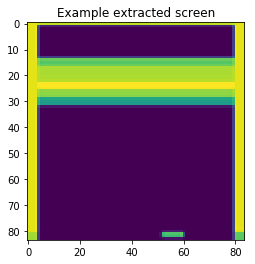

In [5]:
# Тут блок с кодом, генерирующим 1 кадр игры
# Обратите внимание, что выходным тензора является torch.ByteTensor со значениями 0-255
# Это сделанно намеренно для экономии места(4х экономия по сравнению с FloatTensor)
# Подумайте, где и как необходимо совершать преобразование ByteTensort -> FloatTensor, чтобы его можно было подавать в сеть. 

resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach()

# преобразование байта во флоат
def makeFloatFromByte(b):
    return b.type(torch.cuda.FloatTensor).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
# Далее стандартный метод для выбора нового действия из лекции

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

memory = ReplayMemory()
optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4, eps=0.001, alpha=0.95)

def select_action(state, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(makeFloatFromByte(state)).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [7]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(makeFloatFromByte(state_batch)).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(makeFloatFromByte(non_final_next_states)).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

Episode : 0 Steps: 139 Episode score : 0.0 Mean score : 0.0
Episode : 1 Steps: 312 Episode score : 1.0 Mean score : 0.5
Episode : 2 Steps: 441 Episode score : 0.0 Mean score : 0.3333333333333333
Episode : 3 Steps: 601 Episode score : 1.0 Mean score : 0.5
Episode : 4 Steps: 778 Episode score : 1.0 Mean score : 0.6
Episode : 5 Steps: 902 Episode score : 0.0 Mean score : 0.5
Episode : 6 Steps: 1095 Episode score : 2.0 Mean score : 0.7142857142857143
Episode : 7 Steps: 1299 Episode score : 2.0 Mean score : 0.875
Episode : 8 Steps: 1501 Episode score : 1.0 Mean score : 0.8888888888888888
Episode : 9 Steps: 1778 Episode score : 4.0 Mean score : 1.2
Episode : 10 Steps: 2019 Episode score : 3.0 Mean score : 1.3636363636363635
Episode : 11 Steps: 2189 Episode score : 1.0 Mean score : 1.3333333333333333
Episode : 12 Steps: 2353 Episode score : 1.0 Mean score : 1.3076923076923077
Episode : 13 Steps: 2494 Episode score : 0.0 Mean score : 1.2142857142857142
Episode : 14 Steps: 2626 Episode score : 

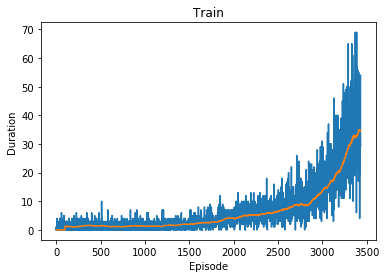

In [8]:
# количество эпизодов, которые играем
NUM_EPISODES = 15000

# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 5
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE= 10000

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 1000

# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000
eps_threshold = EPS_START

policy_net.train()
target_net.eval()

test_rewards = []

# Общее число 
steps_done = 0

# Задание 3. Заполнить пропуски в нижеприведенном коде.

for e in tqdm_notebook(range(NUM_EPISODES)):
    
    # Условие выхода
    if  np.mean(train_rewards[-100:]) >= 35.0 and e >= 100:
        plot_rewards()
        break
    
    # Инициализации разлинычх переменных
    # env - среды
    env.reset()
    # state_holder - хранителя состояния
    state_holder = StateHolder(get_screen())  
    # текущее состояние
    state = state_holder.get()
    # lives - количества жизней в начале эпизода игры (Важно!)
    lives = env.ale.lives()
    # reward'ы за эпизод
    ep_rewards = []
    for t in count():
        
        # Рассчет eps_threshold'а для e-greedy
        if steps_done > EPS_DECAY:
            eps_threshold = EPS_END
        else:
            eps_threshold -= (EPS_START - EPS_END) / EPS_DECAY
        
        # Шаг одного кадра игры 
        steps_done += 1
        
        # действие
        action = select_action(state, eps_threshold)
        _, reward, done, info = env.step(action.item())
        
        # Задание 3.1. Необходимо дополниь код следующим трюком, который значительно
        # улучшает сходимость обучения. В случае, если эпизод не закончился, но агент на 
        # очередном шаге потерял жизнь, то такой переход надо класть в ReplayMemory как финальный.
        # При этом, необходимо далее продолжать эпизод игры, пока не получите done == True
        # Тет самым вы научите агента понимать, что терять жизни по дороге - плохо.
        
        # получаем следующее состояние
        state_holder.push(get_screen())
        ep_rewards.append(reward)

        if done:
            next_state = None
            reward = -1.0
        elif lives > info['ale.lives']:
            next_state = None
            reward = -1.0
            lives = info['ale.lives']
        else:
            next_state = state_holder.get()        
        
        # Работа с ReplayMemory
        memory.push(state, action, next_state, torch.tensor([reward], device=device))
        
        # Код обработки перехода
        state = state_holder.get() if next_state is None else next_state 
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            optimize_model()
        
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            # print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            # Суммарный reward(не дисконтированный) за последний эпизод и средний reward по поsследним 100 эпизодам
            print("Episode : {} Steps: {} Episode score : {} Mean score : {}".format(e, steps_done, train_rewards[-1], np.mean(train_rewards[-100:])))
            # Отрисовка графика
            plot_rewards()
            break 



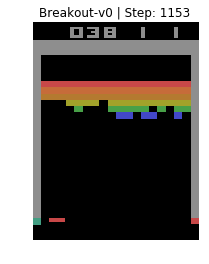

Total game reward : 38.0


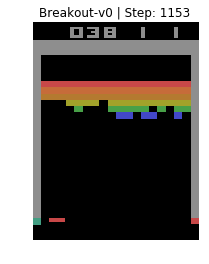

In [11]:
# Тут код для тестирования.
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента, насколько он хорош !?

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


policy_net.eval()
env.reset()
state_holder = StateHolder(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))